# Interactive dEB light curve "quick" fitting tool

In [1]:
# A vain attempt to suppress excessive TF info/warn messages
%env TF_CPP_MIN_LOG_LEVEL 2

env: TF_CPP_MIN_LOG_LEVEL=2


In [2]:
import sys
from pathlib import Path
import re
from ast import literal_eval
import warnings
from multiprocessing import Pool
import json

import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import minimize, OptimizeWarning, show_options
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle, Distance
from mocpy import MOC
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
import lightkurve as lk

warnings.filterwarnings("ignore", "Using UFloat objects with std_dev==0 may give unexpected results.", category=UserWarning)
from uncertainties import UFloat, ufloat

#%matplotlib widget 
import matplotlib.pyplot as plt

# Support for interactive widgets
from IPython.display import *
from ipywidgets import *
from ipyaladin import Aladin, Marker

# Dereddening of SEDS
from dust_extinction.parameter_averages import G23

# MCMC for SEDS
import emcee
from emcee.autocorr import AutocorrError
import corner

from deblib import limb_darkening
from deblib.constants import c
from ebop_maven.estimator import Estimator
from libs import lightcurves, pipeline, plots, jktebop, mcmc_sed, extinction
from libs.sed import get_sed_for_target, group_and_average_fluxes, calculate_vfv
from libs.pyssed import ModelSed

2025-07-21 17:59:03.294047: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753117143.306094   23148 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753117143.309651   23148 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753117143.318236   23148 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753117143.318250   23148 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753117143.318251   23148 computation_placer.cc:177] computation placer alr

<img src="https://www.aanda.org/articles/aa/full_html/2025/02/aa52325-24/aa52325-24-fig3.jpg" alt="Image by Nascimbeni et al. (2025)" width="750"/>

The PLATO LOPS2 long-pointing field as defined by [Nascimbeni et al. (2025)](https://ui.adsabs.harvard.edu/abs/2025A&A...694A.313N) with the HEALPix grids published at [zenodo](https://zenodo.org/records/14720127). 

In [3]:
# MOC (multi-order coverage map) for querying the full LOPS2 field (regardless of the ncam coverage)
lops_moc = MOC.load(path="libs/data/lops2-footprints-moc/PLATOfootprint_hpix9_full_v2.fits")
with open("config/plato-lops2-tess-ebs-targets.json", mode="r", encoding="utf8") as cf:
    targets_config = json.load(cf)

# Get all targets common to both LOPS2 and the source catalogue
all_tebs_lops = lops_moc.query_vizier_table(targets_config.get("source_vizier_table", "J/ApJS/258/16"))
all_tebs_lops.sort("TIC")

In [4]:
tess_ebs_catalog = Vizier(catalog="J/ApJS/258/16", row_limit=1)
gaia_tbosb_catalog = Vizier(catalog="I/357/tbosb2", row_limit=1)
estimator = Estimator()

Estimator loading '/home/steveo/projects/main/platodebcat/.platodebcat/lib/python3.11/site-packages/ebop_maven/data/estimator/default-model.keras'...loaded 'CNN-New-Ext0-bP-4096-None-500k'.
The model CNN-New-Ext0-bP-4096-None-500k was created at 2025-02-17T20:48:17+00:00
The input features are:
  mags_feature as a NDarray[float] of shape (#instances, 4096) containing a phase folded light curve centred on the mid-point between the primary and secondary eclipse
  extra_features as a NDarray of shape (#instances, 0) or None, as no extra_features are used for predictions
The prediction results are:
  predicted values as a structured NDarray[UFloat] of shape (#instances, [rA_plus_rB, k, J, ecosw, esinw, bP])
  optionally, if include_raw is True, all MC predictions as a NDArray[float] of shape (#instances, 6, #iterations)


E0000 00:00:1753117148.427275   23148 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1753117148.427585   23148 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Select the target 
You can select from the TESS-ebs targets within the LOPS2 field or specify your own target.

The target is the object name value used on plots, messages and local cache folder.
The search term is used to search for assets in MAST, which can be the target name
(with or without a V* prefix) or a TIC identifier (9 digit numeric value). The exposure time
constrains the results by the cadence of the observations recorded. For more details see the 
[lightkurve documentation](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.search_lightcurve.html).

In [5]:
# TODO: temp - reload config to pick up latest changes
with open("config/plato-lops2-tess-ebs-targets.json", mode="r", encoding="utf8") as cf:
    targets_config = json.load(cf)

_tebs_mask = (all_tebs_lops["Morph"] >= targets_config.get("morphology_filter", [0, 1])[0]) \
            & (all_tebs_lops["Morph"] <= targets_config.get("morphology_filter", [0, 1])[1]) \
            & (all_tebs_lops["Per"] >= targets_config.get("period_filter", [0, np.inf])[0]) \
            & (all_tebs_lops["Per"] <= targets_config.get("period_filter", [0, np.inf])[1])

_target_configs = targets_config["target_configs"]
_tebs_exclusions = [t for t in _target_configs.keys() if _target_configs[t].get("exclude", False)]
_tebs_mask &= np.in1d(all_tebs_lops["TIC"], _tebs_exclusions, invert=True) # not in exclusions

print(f"Found {len(all_tebs_lops)} target(s) from the TESS-ebs catalog within the LOPS2 field.\nWith",
        f"the application of morphology, period and exclusion criteria {sum(_tebs_mask)} remain.")
tebs_lops = all_tebs_lops[_tebs_mask]

Found 556 target(s) from the TESS-ebs catalog within the LOPS2 field.
With the application of morphology, period and exclusion criteria 208 remain.


In [6]:
_tebs_opts = [(f"{t['TIC']} (Morph={t['Morph']:.3f}; Per={t['Per']:.3f} d)", t['TIC']) for t in tebs_lops]
_default_target = "0032759110"

# TODO: look into selecting exptime based on target_config
_exptime_opts = [("any", None), ("fast (20 s)", "fast"), ("short (60 or 120 s)", "short"), ("long (>= 10 min)", "long")]
display(VBox(children=[
    HBox(children=[
        (_tebs_targs := Dropdown(description="TESS-ebs :", options=_tebs_opts, value=_default_target, layout={'width': "max-content"})),
        (exptime_opt := Dropdown(description="Exposure :", value=targets_config.get("exptime", "short"), options=_exptime_opts)),
    ]),
    HBox(children=[
        (target_text := Text(description="target :", value="", placeholder="name or TIC")),
        (do_prefix := Checkbox(description="prefix non-numeric search term with V*", value=True, layout={'width': "max-content"} )),
    ]),
]))

dlink((_tebs_targs, 'value'), (target_text, 'value'))

### Review Target Information and refine the search

In [7]:
target = f"TIC {int(target_text.value):d}" if target_text.value.isnumeric() else target_text.value
target_config = targets_config["target_configs"].get(target_text.value, { })

search_term = f"V* {target}" if not target.startswith("TIC") and do_prefix.value else target
print(f"The chosen target is '{target}' with search_term '{search_term}'")

target_coords = None
_simbad = Simbad()
_simbad.add_votable_fields("parallax", "allfluxes", "sp", "ids")
if _tbl := _simbad.query_object(search_term):
    target_ids = np.array(re.findall(r"(Gaia DR3|V\*|TIC|HD|HIP|2MASS)\s+(.+?(?=\||$))", _tbl["ids"][0]),
                          dtype=[("type", object), ("id", object)])
    print(f"AKA:       ", ", ".join(id for i in target_ids if (id:=f"{i[0]} {i[1]}") not in [search_term, target]))
    target_coords = SkyCoord(ra=_tbl["ra"][0] * _tbl["ra"].unit,
                             dec=_tbl["dec"][0] * _tbl["dec"].unit,
                             distance=1000 / _tbl["plx_value"][0] * u.pc)
    target_spt = _tbl["sp_type"][0]
    print(f"Coords:    ", f"{target_coords}".replace("\n", ""))
    print(f"SpT:       ", f"{_tbl['sp_type'][0]}")

if _tbl := gaia_tbosb_catalog.query_object(search_term, radius=0.1 * u.arcmin):
    for _row in _tbl:
        print(f"Gaia TBOSB: period={_row['Per'][0]:.6f} d, ecc={_row['ecc'][0]:.6f},",
              f"omega={_row['omega'][0]:.6f}, K1={_row['K1'][0]:.6f}, K2={_row['K2'][0]:.6f}")

The chosen target is 'TIC 32759110' with search_term 'TIC 32759110'
AKA:        Gaia DR3 2915118518547524352, 2MASS J05445791-2456095
Coords:     <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)    (86.2413877, -24.93603146, 39.09976697)>
SpT:        M4.5Ve


In [8]:
_aview = Aladin(fov=1.0, reticle_size=64)
if target_coords:
    _aview.target = target_coords
_aview # Doesn't display if within an if or try block!

Aladin()

In [9]:
# If any include_sectors given then we'll restrict the search
search_results = lk.search_lightcurve(search_term, exptime=exptime_opt.value, sector=target_config.get("include_sectors", None))
suitable_mask = ((search_results.author == "SPOC") | (search_results.author == "TESS-SPOC")) \
                & (search_results.table["dataproduct_type"] == "timeseries") \
                & np.in1d(search_results.target_name, target_ids[target_ids["type"]=="TIC"]["id"]) \
                & np.where(["TESS" in m for m in search_results.mission], True, False)

# Process any configured selection exclusions (automatically uncheck them)
_checked = np.in1d(search_results[suitable_mask].table["sequence_number"], target_config.get("exclude_sectors", []), invert=True)

# Give user a chance to override any pre-selection of sectors and set the flux column and quality bitmask
_target_box = Accordion(children=[
    VBox(children=(sec_checks := 
        [Checkbox(description="toggle all", value=True, indent=False)] + 
        [Checkbox(description=f"{r.mission[0]} ({r.year[0]}): author={r.author[0]}, target={r.target_name[0]}, exptime={r.exptime[0]}", value=bool(chk),
                  indent=False, layout={'width': "max-content"}) for r, chk in zip(search_results[suitable_mask], _checked)]
    )),
    HBox(children=[
        (flux_column := widgets.Dropdown(description="flux_column :", options=["sap_flux", "pdcsap_flux"],
                                         value=target_config.get("flux_column", "sap_flux"), style={'description_width': 'max-content'})),
        (quality_bitmask := widgets.Dropdown(description="quality_bitmask :", options=["default", "hard", "hardest"],
                                             value=target_config.get("quality_bitmask", "hardest"), style={'description_width': 'max-content'})),
    ])
], titles=[f"The {sum(suitable_mask)} sector(s) found for {target}", "Flux column and quality bitmask"])

def toggle_all(_):
    for cb in sec_checks[1:]: cb.value = sec_checks[0].value
sec_checks[0].observe(toggle_all)
_target_box.selected_index = 0
display(_target_box)

Accordion(children=(VBox(children=(Checkbox(value=True, description='toggle all', indent=False), Checkbox(valu…

### Download the light curves of the chosen sectors
For details of the flux_column and quality_bitmask arguments see the documentation for
[download](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.SearchResult.download.html#lightkurve.SearchResult.download).
The find_lightcurves() function will attempt to service the request from the
local cache in preference to contacting MAST.

In [10]:
_select_mask = np.array([sec_checks[i].value for i in range(1, len(sec_checks))], dtype=bool)
num_sectors = sum(_select_mask)
target_file_stem = re.sub(r"[^\w\d]", "-", target.lower())
lcs = lightcurves.load_lightcurves(search_results[suitable_mask][_select_mask], quality_bitmask.value,
                                   flux_column.value, Path.cwd() / ".cache" / target_file_stem)

### Plot the selected light curves

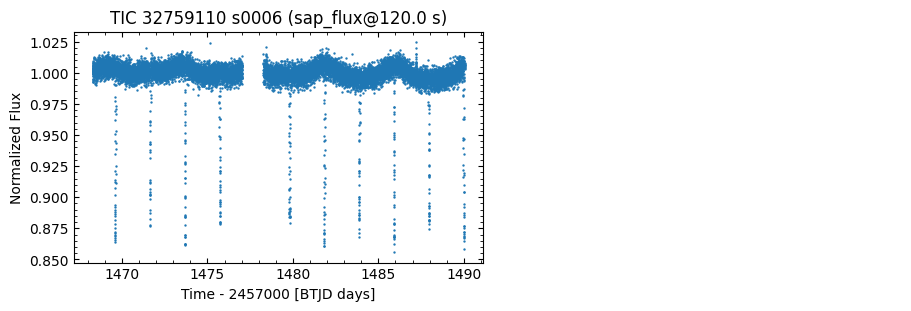

In [11]:
lcs_titles = [f"{target} s{l.sector:04d} ({l.meta['FLUX_ORIGIN']}@{l.meta['FRAMETIM']*l.meta['NUM_FRM']} s)" for l in lcs]
plt.show(_fig := plots.plot_lightcurves(lcs, "flux", lcs_titles, normalize_lcs=True))
plt.close(_fig)

### Process the light curves to create flattened copies with delta_mag columns

First we select regions to exclude from processing. These could be distorted regions of the
light curve, incomplete eclipses or isolated regions with no useful data. Currently there is
no tool for selecting ranges from the light curve plot directly, so instead we parse the text
of an exclude list of (from, to) time tuples taken from all sectors. For example;
```python
[(1420.0, 1424.0), (2158.0, 2160.0)]
```
where the time values are interpreted with the time format and scale of each light curve.

Once we have any time masks we can use these, along with a simple mask which excludes
invalid flux values, to create masked copies of the original light curves. The masked
light curves are then extended with `delta_mag` and `delta_mag_err` columns calculated
from the fluxes. The `delta_mag` values are detrended and rectified in contiguous segments,
which are selected by finding gaps in the timeseries > gap threshold. Each segment is
rectified and detrended by subtracting a fitted polynomial of the selected degree. 

In [12]:
display(VBox(children=[
    (combine_sectors := Checkbox(description=f"Combine {num_sectors} sector(s)", value=target_config.get("combine_sectors", False),
                                 indent=False, layout={"width": "25%"}, style={'description_width': 'max-content'})),
    (time_masks_text := Text(description="Time ranges to exclude:", value=f"{target_config.get('quality_masks', '')}",
                             layout={'width': "50%"}, style={'description_width': 'max-content'})),

    (seg_gap_th := FloatLogSlider(description="segment gap threshold (d):", value=target_config.get("detrend_gap_th", 2.0),
                                  base=10, min=-1, max=3, layout={"width": "25%"}, style={'description_width': 'max-content'})),
    HBox(children=[
        (poly_degr := IntSlider(description="detrend poly degree:", value=target_config.get("detrend_poly_degree", 1),
                                min=1, max=4, layout={"width": "25%"}, style={'description_width': 'max-content'})),
        (dtrd_iters := IntSlider(description="detrend iterations:", value=target_config.get("detrend_iterations", 2),
                                 min=1, max=4, layout={"width": "25%"}, style={'description_width': 'max-content'})),
])]))

In [13]:
time_mask_list = []
if len(time_masks_text.value.strip()): # Interpret the list of (from, to) tuples entered above
    time_mask_list = literal_eval(time_masks_text.value)
    if isinstance(time_mask_list, (tuple, int, float)):
        time_mask_list = [time_mask_list]

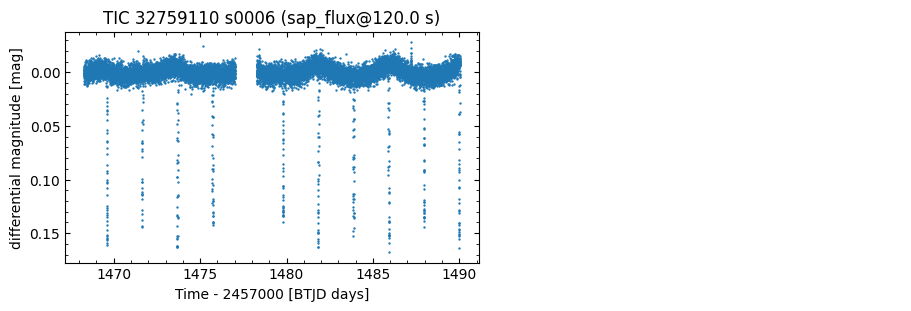

In [14]:
mag_lcs = lk.LightCurveCollection([])
if combine_sectors.value and len(lcs):
    _norm_lcs = [lcs.stitch(lambda lc: lc.normalize())]
    lcs_titles = [f"{target} over {num_sectors} sector(s)"]
else:
    _norm_lcs = (lc.normalize() for lc in lcs)
    
for norm_lc in _norm_lcs:
    # Mask out any invalid fluxes and requested time ranges
    _qual_mask = lightcurves.create_invalid_flux_mask(norm_lc)
    for time_mask_range in (lightcurves.to_lc_time(t, norm_lc) for t in time_mask_list):
        _qual_mask &= (norm_lc.time < np.min(time_mask_range)) | (norm_lc.time > np.max(time_mask_range))
    norm_lc = norm_lc[_qual_mask]

    # Create detrended & rectified delta_mag and delta_mag err columns
    lightcurves.append_magnitude_columns(norm_lc, "delta_mag", "delta_mag_err")
    for s in lightcurves.find_lightcurve_segments(norm_lc, threshold=seg_gap_th.value * u.d):
        norm_lc[s]["delta_mag"] -= lightcurves.fit_polynomial(norm_lc.time[s], norm_lc[s]["delta_mag"],
                                                              poly_degr.value, dtrd_iters.value, 1.0)
    mag_lcs.append(norm_lc)
del _norm_lcs

plt.show(_fig := plots.plot_lightcurves(mag_lcs, "delta_mag", lcs_titles))
plt.close(_fig)

### Review phase folded light curves
First we lookup for the system's ephemeris in the TESS-ebs catalogue based on its TIC. If nothing found then the primary epoch and orbital period must be set manually by inspecting the light curves above.

By default the T0 time is expected to be the time of a primary eclipse. The phase folded light curves will be phase normalized when folded about this point (which becomes phase 0).

In [15]:
_default_t0, _default_period = None, None
if (result := tess_ebs_catalog.query_object(mag_lcs[0].meta["OBJECT"])):
    _default_t0, _default_period = result[0]["BJD0"][0], result[0]["Per"][0]
elif (result := gaia_tbosb_catalog.query_object(search_term)):
    _default_period = result[0]["Per"][0]

display(HBox(children=[
    (t0_text := FloatText(description="Primary epoch (btjd):",  value=target_config.get("t0",  _default_t0),
                          style={'description_width': 'max-content'})),
    (period_text := FloatText(description="Orbital period (d):", value=target_config.get("period", _default_period),
                              style={'description_width': 'max-content'})),
    (double_check := Checkbox(description="Use orbital period x2", value=target_config.get("double_period", False),
                              style={"description_width": "max-content"})),
]))

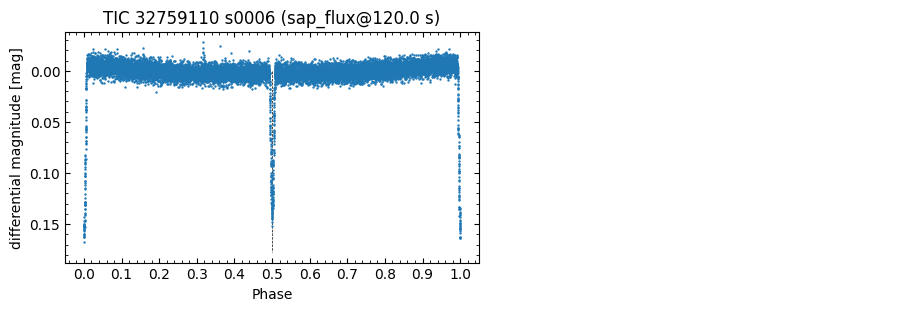

In [16]:
t0 = lightcurves.to_lc_time(t0_text.value, mag_lcs[0])
period = (2 if double_check.value else 1) * (period_text.value * u.d)

def _format_phases(_, ax):
    ax.vlines([0.5], 0, max(ax.get_ylim()), "k", "--", lw=0.5, zorder=-10)
    ax.set_xticks(np.arange(0.0, 1.1, 0.1))

_fig = plots.plot_lightcurves([*(lc.fold(period, t0, wrap_phase=u.Quantity(1), normalize_phase=True) for lc in mag_lcs)],
                             "delta_mag", lcs_titles, ax_func=_format_phases)
plt.show(_fig)
plt.close(_fig)

### Create sampled, phase folded mags data for use with EBOP MAVEN
We now need to make sampled copies of phase folded & phase normalized light curves for
each sector. The EBOP MAVEN model will tell us what wrap it expects for the folded light curves
for estimations through its `mags_feature_wrap_phase` attribute. This will have a value between
0 and 1, or `None`;
- a numeric value indicates the fixed phase above which phased data is expected to be wrapped
to a negative phase
    - a value of 0.75 indicates a phase range of -0.24999 to 0.75, centred on phase 0.25
- a value of `None` indicates the wrap is to ensure the resulting data is centred on the
mid-point between the primary and secondary eclipse
    - in this case the value is calculated from the phase of the secondary eclipse
    which can be set below

In [17]:
if estimator.mags_feature_wrap_phase is None:
    display(HBox(children=[
        (phiS_slider := FloatSlider(description="Phase of secondary eclipse:", value=target_config.get("phiS", 0.5),
                                    min=.01, max=.99, step=.01, layout={"width": "33%"}, style={'description_width': 'max-content'})),
    ]))

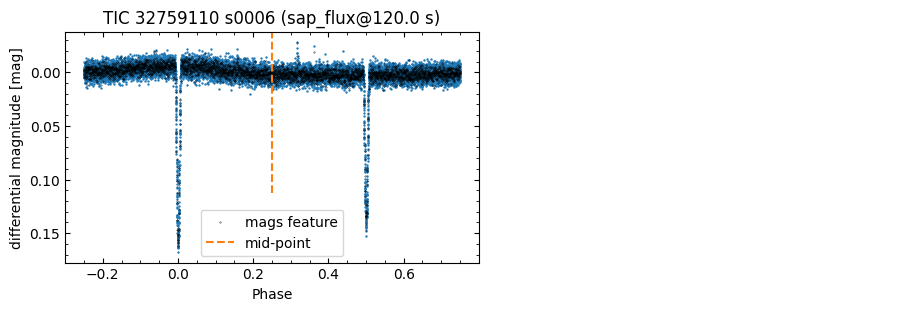

In [18]:
mags_bins = estimator.mags_feature_bins
wrap_phase = u.Quantity(estimator.mags_feature_wrap_phase or (0.5 + phiS_slider.value / 2))
samp_mags = np.zeros(shape=(len(mag_lcs), 2, mags_bins), dtype=np.float32)

_flcs = []
for ix, lc in enumerate(mag_lcs):
    _flcs.append(flc := lc.fold(period, t0, wrap_phase=wrap_phase, normalize_phase=True))
    samp_mags[ix] = lightcurves.get_sampled_phase_mags_data(flc, mags_bins, wrap_phase)

def _sample_and_mid(ix, ax):
    ax.scatter(samp_mags[ix, 0], samp_mags[ix, 1], s=0.33, c="k", marker=".", label="mags feature")
    ax.vlines(0.5, 0.3, 1, "tab:orange", "--", lw=1.5, transform=ax.transAxes, label="mid-point")

_fig = plots.plot_lightcurves(_flcs, "delta_mag", lcs_titles, ax_func=_sample_and_mid, legend_loc="best")
plt.show(_fig)
plt.close(_fig)

### Estimate fitting input parameters with EBOP MAVEN
The EBOP MAVEN model will predict values for $r_{\rm A}+r_{\rm B}$, $k$, $J$, $e\cos{\omega}$,
$e\sin{\omega}$ and $b_{\rm P}$ for use as `JKTEBOP` fitting input parameters. To these we will
need to add values for $i$, which can be calculated from the 6 predicted values.

In [19]:
predictions = estimator.predict(samp_mags[:, 1], iterations=1000)
predictions = pipeline.append_calculated_inc_predictions(predictions, "inc")

for lc, preds in zip(mag_lcs, predictions):
    print(f"\nJKTEBOP input parameters for {target} sector {lc.meta['SECTOR']}")
    print(*(f"{p:>12s}: {preds[p] or 0:11.6f}" for p in predictions.dtype.names), sep="\n")


JKTEBOP input parameters for TIC 32759110 sector 6
  rA_plus_rB:    0.056733+/-   0.026309
           k:    0.823380+/-   0.061701
           J:    2.913924+/-   0.372009
       ecosw:    0.001920+/-   0.012643
       esinw:    0.202663+/-   0.045033
          bP:    0.828769+/-   0.089013
         inc:   88.146687+/-   0.890916


### Estimate limb darkening parameters
We have starting effective temperature and surface gravity values in the
TESS metadata stored with the light curves, however this refers to system
as a whole. We use J as a simple proxy for the ratio of effective temperatures.

In [20]:
teff_sys = ufloat(mag_lcs[0].meta.get("TEFF", None) or 5650, 300)
logg_sys = ufloat(mag_lcs[0].meta.get("LOGG", None) or 4.0, 0.1)

_J = np.mean(predictions["J"])
_teff = (teff_sys, teff_sys * _J) if _J.n < 1 else (teff_sys / _J, teff_sys)
display(VBox(children=[
    HBox(children=[
        (teffA_text := FloatSlider(description="Effective temp star A (K):", value=_teff[0].n, min=2300, max=12000, layout={"width": "25%"}, style={'description_width': 'max-content'})),
        (loggA_text := FloatSlider(description="log(g) star A (dex):", value=logg_sys.n, min=2.5, max=6.0, step=0.5, style={'description_width': 'max-content'})),    
    ]),
    HBox(children=[
        (teffB_text := FloatSlider(description="Effective temp star B (K):", value=_teff[1].n, min=2300, max=12000, layout={"width": "25%"}, style={'description_width': 'max-content'})),
        (loggB_text := FloatSlider(description="log(g) star A (dex):", value=logg_sys.n, min=2.5, max=6.0, step=0.5, style={'description_width': 'max-content'})),
    ]),
]))

In [21]:
_ldA_coeffs = limb_darkening.lookup_pow2_coefficients(loggA_text.value, teffA_text.value)
_ldB_coeffs = limb_darkening.lookup_pow2_coefficients(loggB_text.value, teffB_text.value)
ld_params = {
    "LDA": "pow2", "LDA1": _ldA_coeffs[0], "LDA2": _ldA_coeffs[1],
    "LDB": "pow2", "LDB1": _ldB_coeffs[0], "LDB2": _ldB_coeffs[1],
}

### Perform JKTEBOP Task 3 analysis
First we set up the in and dat files for each analysis to be run.

In [22]:
# Superset of all of the potentially fitted parameters
fitted_param_names = ["rA_plus_rB", "k", "J", "ecosw", "esinw", "inc", "L3", "pe", "period", "rA", "rB", "LA", "LB", "light_ratio"]
fitted_params = np.empty(shape=(len(mag_lcs), ), dtype=[(k, np.dtype(UFloat.dtype)) for k in fitted_param_names])

In [23]:
task = 3
fit_dir = jktebop.get_jktebop_dir()
file_fmt = f"quick-fit-{target_file_stem}-{{sector:04d}}.{{ext:s}}"
for ix, (lc, preds) in enumerate(zip(mag_lcs, predictions)):
    _in_fname = fit_dir / file_fmt.format(sector=lc.meta['SECTOR'], ext="in")
    _dat_fname = fit_dir / file_fmt.format(sector=lc.meta['SECTOR'], ext="dat")
    _par_fname = fit_dir / file_fmt.format(sector=lc.meta['SECTOR'], ext="par")

    _in_params = {
        "task": task,
        "qphot": preds["k"]**1.4,
        "gravA": 0.,                "gravB": 0.,
        "L3": 0.,

        "reflA": 0.,                "reflB": 0.,
        "period": period.value,
        "primary_epoch": t0.value,
        
        "simulations": 100 if task == 8 else "",

        "qphot_fit": 0,
        "ecosw_fit": 1,             "esinw_fit": 1,
        "gravA_fit": 0,             "gravB_fit": 0,
        "L3_fit": 1,
        "LDA1_fit": 1,              "LDB1_fit": 1,
        "LDA2_fit": 0,              "LDB2_fit": 0,
        "reflA_fit": 1,             "reflB_fit": 1,
        "sf_fit": 1,
        "period_fit": 1,            "primary_epoch_fit": 1,

        "data_file_name": _dat_fname.name,
        "file_name_stem": _dat_fname.stem,

        **{ n: preds[n] for n in preds.dtype.names },
        **ld_params,
    }

    # JKTEBOP will fail if it finds files from a previous fitting
    for file in fit_dir.glob(file_fmt.format(sector=lc.meta["SECTOR"], ext="*")):
        file.unlink()
    _segments = lightcurves.find_lightcurve_segments(lc, 0.5, yield_times=True)
    _append_lines = jktebop.build_poly_instructions(_segments, "sf", 1) + ["", "chif", ""]
    jktebop.write_in_file(_in_fname, append_lines=_append_lines, **_in_params)
    jktebop.write_light_curve_to_dat_file(lc, _dat_fname)

    # Blocks on the JKTEBOP task until we can parse the newly written par file contents
    # to read out the revised values for the superset of potentially fitted parameters.
    _pgen = jktebop.run_jktebop_task(_in_fname, _par_fname, stdout_to=sys.stdout)
    for k, v in jktebop.read_fitted_params_from_par_lines(_pgen, fitted_param_names, True).items():
        fitted_params[ix][k] = v

  
JKTEBOP  v44  John Southworth (Keele University, UK, taylorsouthworth~gmail.com)
Task 3  finds the best fit of the model to observations  (formal errorbars only)
>> Read parameters for polynomial  1, to be applied to parameter "sf" over a given time interval
>> Read parameters for polynomial  2, to be applied to parameter "sf" over a given time interval
>> Opened new parameter  file:  quick-fit-tic-32759110-0006.par                   
>> Opened new LC output  file:  quick-fit-tic-32759110-0006.out                   
>> Opened new model fit  file:  quick-fit-tic-32759110-0006.fit                   
>> Read  14574 datapoints (with errors) from file quick-fit-tic-32759110-0006.dat                   
>> Read  2 polynomial datasets from the input file
>> Best fit has been found after 26 iterations.
>> Done iteration 1 to adjust errorbars. Chisqred values:   1.025 
>> Done iteration 2 to adjust errorbars. Chisqred values:   1.000 
>> Best fit has been found after 12 iterations.
  


#### Report of JKTEBOP fitting results

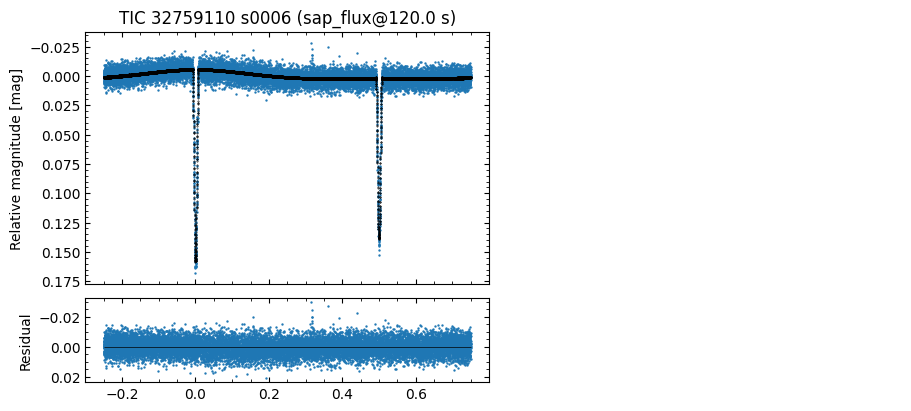

In [24]:
if task == 3:
    rows, cols = int(np.ceil(len(mag_lcs) / 2)), 2
    fig, axes = plt.subplots(rows*2, cols, figsize=(4.5*cols, 4*rows), height_ratios=(3, 1)*rows, constrained_layout=True)

    for ix in range(axes.size//2):
        row, col = int(np.floor(ix / cols) * 2), ix % cols
        ax_lc, ax_res = axes[row, col], axes[row+1, col]
        if ix < len(mag_lcs):
            # Pick columns so they are ordered [phase, lc_mag, model_mag, residual]
            out_file = fit_dir / file_fmt.format(sector=mag_lcs[ix].meta['SECTOR'], ext="out")
            out_data = np.loadtxt(out_file, float, comments="#", usecols=[3, 1, 4, 5], unpack=True)
            out_data[0][out_data[0] > wrap_phase.value] -= 1. # matches wrap used previously
        
            if ix < len(mag_lcs):
                ax_lc.scatter(out_data[0], out_data[1], s=2.0, marker=".", label=None)
                ax_lc.scatter(out_data[0], out_data[2], s=0.5, c="k", marker=".", label=None)
                ax_res.scatter(out_data[0], out_data[3], s=2.0, marker=".", label=None)
                ax_res.hlines([0.0], min(out_data[0]), max(out_data[0]), ls="-", color="k", lw=.5)

                if ix == 0:
                    ax_lc.invert_yaxis()
                    ax_res.invert_yaxis()
                else:
                    ax_lc.sharey(axes[0, 0])
                    ax_res.sharey(axes[1, 0])
        
                # Hides tick labels on inner facing shared axes
                plt.setp(ax_lc.get_xticklabels(), visible=False) 
                if col > 0:
                    plt.setp(ax_lc.get_yticklabels(), visible=False)
                    plt.setp(ax_res.get_yticklabels(), visible=False)
                plots.format_axes(ax_lc, title=lcs_titles[ix], ylabel="" if ix % cols else "Relative magnitude [mag]")
                plots.format_axes(ax_res, ylabel="" if ix % cols else "Residual")
        else:
            ax_lc.axis("off")
            ax_res.axis("off")
    plt.show(fig)
    plt.close(fig)

In [25]:
print(("Mean f" if len(fitted_params) > 1 else "F") + f"itted parameter values for {target} over {num_sectors} sector(s)")
print("\n".join(f"{p:>14s}: {fitted_params[p].mean():12.6f}" for p in fitted_params.dtype.names))

Fitted parameter values for TIC 32759110 over 1 sector(s)
    rA_plus_rB:     0.059463+/-    0.004549
             k:     0.682991+/-    0.104132
             J:     1.614532+/-    0.296352
         ecosw:    -0.000055+/-    0.000038
         esinw:     0.074353+/-    0.023118
           inc:    88.227498+/-    0.460013
            L3:     0.274397+/-    0.204034
            pe:  1469.606843+/-    0.000098
        period:     4.076977+/-    0.000029
            rA:     0.035332+/-           0
            rB:     0.024131+/-           0
            LA:     0.495174+/-           0
            LB:     0.230428+/-           0
   light_ratio:     0.465348+/-           0


### Load our support data for MCMC fitting the target's SED

Load the PySSED bt-settle model and set up the related model functions.

__Note:__ The data file is currently a copy of that kindly published on [GitHub](https://github.com/iain-mcdonald/PySSED)
by [McDonald at al., (2024)](https://ui.adsabs.harvard.edu/abs/2024RASTI...3...89M/abstract)

In [26]:
# Read the pre-built bt-settl model file
model_sed = ModelSed("libs/data/pyssed/model-bt-settl-recast.dat")

print(f"Loaded previously built dataset of solar metallicity pyssed spectra covering the ranges:")
print(f"wavelength {model_sed.wavelength_range:unicode}, Teff {model_sed.teff_range:unicode}",
      f"and logg {model_sed.logg_range:unicode}")

Loaded previously built dataset of solar metallicity pyssed spectra covering the ranges:
wavelength [ 0.3 22. ] µm, Teff [ 1900. 70000.] K and logg [-0.5  6. ] dex


In [27]:
# Extinction model: G23 (Gordon et al., 2023) Milky Way R(V) filter gives us the broadest coverage
ext_model = G23(Rv=3.1)
ext_wl_range = np.reciprocal(ext_model.x_range) * u.um # x_range has implicit units of 1/micron
print(f"Using the {ext_model.__class__.__name__} extinction model which covers the range from",
      f"{min(ext_wl_range)} to {max(ext_wl_range)}.")

Using the G23 extinction model which covers the range from 0.0912 um to 32.0 um.


### Locate and prepare the target's spectral energy distribution (SED) data
We can query the target's SED with the Vizier SED service which aggregates
flux measurements from various systematic sky surveys. Once we have this
we need to deredden the SED prior to fitting for stellar masses

In [28]:
# Read in the SED for this target and de-duplicate (measurements may appear multiple times).
# Work in Jy rather than W/m^2/Hz as they are a more natural unit, giving values that minimize 
# potential FP rounding. Plots are agnostic and plot wl [um] and vF(v) [W/m^2] on x and y.
sed = get_sed_for_target(target, search_term, radius=0.1, remove_duplicates=True, verbose=True,
                         freq_unit=u.GHz, flux_unit=u.Jy, wl_unit=u.um)

sed = group_and_average_fluxes(sed, verbose=True)

# Filter SED to those covered by our models and also remove any outliers
_model_mask = np.ones((len(sed)), dtype=bool)
_model_mask &= np.array([model_sed.has_filter(f) for f in sed["sed_filter"]])
_model_mask &= (sed["sed_wl"] >= min(ext_wl_range)) & (sed["sed_wl"] <= max(ext_wl_range)) \
            & (sed["sed_wl"] >= min(model_sed.wavelength_range)) & (sed["sed_wl"] <= max(model_sed.wavelength_range))
sed = sed[_model_mask]

_out_mask = np.zeros_like(_model_mask[_model_mask], dtype=bool)
# _out_mask |= create_outliers_mask(sed, theta0[:2], min_unmasked=15, verbose=True)
sed = sed[~_out_mask]
sed.sort(["sed_wl"])
print(f"{len(sed)} unique SED observation(s) retained after range and outlier filtering",
      "\nwith the units for flux, frequency and wavelength being",
      ", ".join(f"{sed[f].unit:unicode}" for f in ["sed_flux", "sed_freq", "sed_wl"]))

Opened SED table tic-32759110-0.1.vot containing 32 row(s).
Dropped 13 duplicate(s) leaving 19 unique row(s).
Grouped SED by ['sed_filter', 'sed_freq'] yielding 13 group(s) from 19 row(s).
Calculating the group means of the [('sed_flux', 'sed_eflux')] columns
12 unique SED observation(s) retained after range and outlier filtering 
with the units for flux, frequency and wavelength being Jy, GHz, µm


In [29]:
for val, flags in extinction.get_ebv(target_coords, rv=ext_model.Rv):
    if val and not np.isnan(val) and flags.get("converged", False):
        print(f"Found extinction with {flags['source']}: E(B-V) = {val:.6f}")
        sed["sed_der_flux"] = sed["sed_flux"] / ext_model.extinguish(sed["sed_wl"].to(u.um), Ebv=val)
        break

if "sed_der_flux" in sed.colnames:
    der_lab = "dereddened"
else:
    sed["sed_der_flux"] = sed["sed_flux"]
    der_lab = "not dereddened"

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.
Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 25.859 s
  pix_info:   0.364 s
   samples:  14.762 s
      best:   2.833 s
       nan:   0.020 s
      sort:   7.782 s
       idx:   0.098 s
Querying Galactic interstellar dust Gaia-2MASS 3D maps (2022A&A...664A.174V) for extinction data.
Found extinction with get_vergely_av: E(B-V) = 0.004483


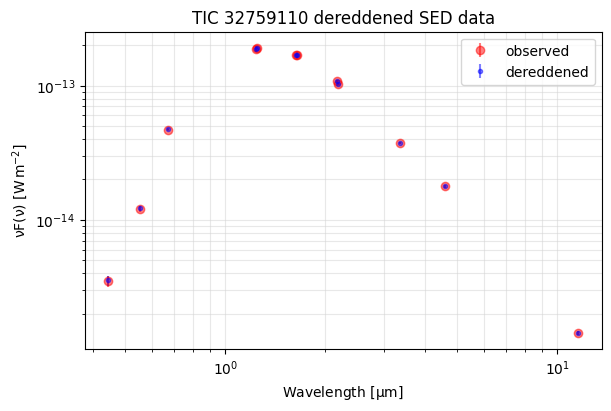

In [30]:
_fig, _ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
_ax.errorbar(sed["sed_wl"].to(u.um), *calculate_vfv(sed, unit=u.W/u.m**2), fmt="or", alpha=0.5, label="observed")
_ax.errorbar(sed["sed_wl"].to(u.um), *calculate_vfv(sed, flux_colname="sed_der_flux", unit=u.W/u.m**2), fmt=".b", alpha=0.5, label=der_lab)
_ax.set(title=f"{target} dereddened SED data",
        xscale="log", xlabel=f"Wavelength [{u.um:latex_inline}]",
        yscale="log", ylabel=f"${{\\rm \\nu F(\\nu)}}$ [{u.W/u.m**2:latex_inline}]")
_ax.grid(True, which="both", axis="both", alpha=0.5, color="lightgray")
_ax.legend(loc="best")
plt.show(_fig)
plt.close(_fig)

### Set up the functions which will support SED fitting

Here we set up the known priors and the **prior_func** which will be called during fitting
to return whether the current `theta` conforms to these criteria (returning 0), or not (np.inf).

In [31]:
MIN_TEFF, MAX_TEFF = model_sed.teff_range.to(u.K).value
MIN_LOGG = max(0.0, model_sed.logg_range.value.min())
MAX_LOGG = model_sed.logg_range.value.max()
print(f"Priors from synthetic data:\t{MIN_TEFF} < T_eff < {MAX_TEFF} [K] and {MIN_LOGG:.3f} < logg < {MAX_LOGG:.3f} [dex]")

# Target specific priors originating from LC fit (teff ratio based on L = 4pi*R^2*sigma_sb*Teff^4)
teff_ratio = (fitted_params["light_ratio"].mean() / fitted_params["k"].mean()**2)**0.25
teff_flex = max(teff_ratio.n * 0.1, teff_ratio.s)
print(f"Priors from LC fitting:\t\tT_eff ratio={teff_ratio.n:.6f} +/- flex of {teff_flex:.6f}")

def prior_func(theta) -> float:
    if all(MIN_LOGG < l < MAX_LOGG for l in theta[2:]) \
        and all(MIN_TEFF < t < MAX_TEFF for t in theta[:2]) \
        and abs(theta[1]/theta[0] - teff_ratio.n) < teff_flex:
        return 0
    return np.inf

Priors from synthetic data:	1900.0 < T_eff < 70000.0 [K] and 0.000 < logg < 6.000 [dex]
Priors from LC fitting:		T_eff ratio=0.999394 +/- flex of 0.099939


The **model_func** will calculate a set of model SED flux data at points `x` for the current `theta`.
The implementation `scaled_summed_model(x, theta)` scales these model data to the known SED
fluxes before returning them.

In [32]:
_flux_unit = sed["sed_der_flux"].unit
_y_log = np.log10(sed["sed_der_flux"].quantity.value)

def scaled_summed_model(theta, x):
    teffA, teffB, loggA, loggB = theta
    # Scale the model to the obs' in log10 space as the range of potential values is very wide
    y_model_log = np.log10(np.add(
        model_sed.get_fluxes(x, teffA, loggA).value,
        model_sed.get_fluxes(x, teffB, loggB).value))
    if _flux_unit != u.Jy and model_sed.flux_unit == u.Jy:
        y_model_log -= 26
    return 10**(y_model_log + np.median(_y_log - y_model_log))

def weighted_chi_sq(y_model, y, w, degree_freedom=len(_y_log)-4) -> float:
    """ chi^2_w = 1/(N_obs-n_param) * Σ W(y-y_model)^2 """
    return np.sum(w * (y - y_model)**2) / degree_freedom

The **objective_func** (ln_prob_func in emcee "speak") is the function which will be optimized.
It pulls together `prior_func` to evaluate the current `theta` against the prior criteria and then
calculates and returns the $\chi^2_w$ value of the `scaled_summed_model` (based on `theta`) against
the observations.

**Note:** If `maximizable==True` the return values will be negated to support an emcee
`EnsembleSampler` which seeks to maximize this value. Otherwise the value will be positive which
supports scipy `minimize` optimization, which seeks to minimize the return values.

In [33]:
def objective_func(theta, x, y, w, maximizable: bool=False) -> float:
    """
    This is the function to be optimized to fit a model to the SED data

    :theta: the current set of parameters being fitted
    :x: the filters used for each of the observed fluxes
    :y: the observed fluxes
    :w: the weights to use for the weighted chi^2 evaluation
    :maximizable: whether this function is being minimized (False) or maximized by MCMC (True)
    :returns: a single value representing the likeness between the model and observations
    """
    if np.isfinite(retval := prior_func(theta)):
        retval += weighted_chi_sq(scaled_summed_model(theta, x), y, w)
        retval = np.nan_to_num(retval, nan=np.inf)
    return -retval if maximizable else retval

Set up the fixed values used for each fitting iteration. These are the sed filters (x), the
observed fluxes (y) and the fitting weights (w). The default approach for the weights is to
use 1/variance (1/sed_eflux^2) which effectively leads to the calculation of the reduced chisq
($\chi^2_r$). The weights can be modified further by setting `_wt_mod` (for example to weight
in favour of observations nearer the expected black-body peak wavelength).

In [34]:
# Weights for chisq eval; with default of mod==1 we have 1/var, effectively giving us reduced chisq.
# This approach to the weights allows us to potentially prioritize observations near the BB peak.
_bb_peak_lambda = 2.897771955e3 / teff_sys.n # um
_sed_lambda = sed["sed_wl"].to(u.um).value
_wt_mod = 1 / 1**abs((_sed_lambda - _bb_peak_lambda) / (_sed_lambda.max() - _bb_peak_lambda))
_wt = _wt_mod / sed["sed_eflux"].quantity.value**2
print(f"The fitting chisq weights are calculated as [", ", ".join(f"{m:.3f}" for m in _wt_mod),
      "] / sed_eflux^2\ngiving [", ", ".join(f"{w:.3e}" for w in _wt), "]")

# Everything after theta in the arg list is effectively fixed for each fitting - set them now
obj_args = ( # x, y, W
    model_sed.get_filter_indices(sed["sed_filter"]),
    sed["sed_der_flux"].quantity.value,
    _wt 
)

The fitting chisq weights are calculated as [ 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000 ] / sed_eflux^2
giving [ 4.726e+08, 8.264e+07, 3.963e+07, 6.530e+04, 3.460e+05, 2.500e+05, 4.492e+04, 3.460e+05, 3.460e+05, 1.235e+06, 4.000e+06, 3.906e+07 ]


Finally, we set up `theta0` which is the starting position for fitting based on published values
for $T_{\rm eff}$ and $\log{g}$ and the `teff_ratio` calculated from the fitted parameters.

In [35]:
_logg_sys_round = np.round(logg_sys.n * 10) / 10
if teff_ratio.n <= 1:
    theta0 = [round(teff_sys.n), round(teff_sys.n * teff_ratio.n), _logg_sys_round, _logg_sys_round]
else:
    theta0 = [round(teff_sys.n / teff_ratio.n), round(teff_sys.n), _logg_sys_round, _logg_sys_round]

theta_labels = [("TeffA", model_sed.teff_range.unit), ("TeffB", model_sed.teff_range.unit),
                ("loggA", model_sed.logg_range.unit), ("loggB", model_sed.logg_range.unit)]
print(f"For {target} we set the starting position (theta0) to be:",
      *(f"\n{l:>9s} = {t: .3f} {unit:unicode}" for t, (l, unit) in zip(theta0, theta_labels)))

For TIC 32759110 we set the starting position (theta0) to be: 
    TeffA =  3119.000 K 
    TeffB =  3117.000 K 
    loggA =  4.900 dex 
    loggB =  4.900 dex


#### Run a "quick" minimize fit

In [36]:
with warnings.catch_warnings(category=[RuntimeWarning, OptimizeWarning]):
    warnings.filterwarnings("ignore", message="invalid value encountered in subtract")
    warnings.filterwarnings("ignore", message="Desired error not necessarily achieved due to precision loss.")
    warnings.filterwarnings("ignore", message="Unknown solver options:")

    _soln, _soln_type = None, None
    for method in [None, "Nelder-Mead", "SLSQP"]:
        this_soln = minimize(objective_func, x0=theta0, args=obj_args, method=method, options={ "maxiter": 5000, "maxfev": 5000 })      
        print(f"(method={method}) {'succeed' if this_soln.success else 'fail'}ed [{this_soln.message}] after",
            f"{this_soln.nit} iteration(s) & {this_soln.nfev} function evaluation(s) [fun = {this_soln.fun:.6f}]")
        if _soln is None or (not _soln.success and this_soln.success) or (_soln.fun > this_soln.fun):
            _soln, _soln_type = this_soln, method

# Read the resulting fitted values
print(f"Using the best fit which is from {_soln_type}")
theta_fit = _soln.x
theta_err_high = np.zeros_like(_soln.x, dtype=float)
theta_err_low = np.zeros_like(_soln.x, dtype=float)

(method=None) failed [Desired error not necessarily achieved due to precision loss.] after 0 iteration(s) & 48 function evaluation(s) [fun = 43.571816]
(method=Nelder-Mead) succeeded [Optimization terminated successfully.] after 534 iteration(s) & 900 function evaluation(s) [fun = 2.505242]
(method=SLSQP) succeeded [Optimization terminated successfully] after 50 iteration(s) & 427 function evaluation(s) [fun = 20.355526]
Using the best fit which is from Nelder-Mead


In [37]:
def plot_fitted_model(theta):   
    teffA, teffB, loggA, loggB = theta
    filter_ixs = model_sed.get_filter_indices(sed["sed_filter"])
    flux_unit = sed["sed_der_flux"].unit
    sed_wl = sed["sed_wl"].to(u.um)

    # The baseline dereddened observed SED data in nu*F(nu) form
    obs_der_vfv, obs_der_evfv = calculate_vfv(sed, flux_colname="sed_der_flux", unit=u.W / u.m**2)

    # Generate a model SED from the fitted values in nu*F(nu) form for plotting
    raw_mod_fluxes = np.array([model_sed.get_fluxes(filter_ixs, teffA, loggA).value,
                               model_sed.get_fluxes(filter_ixs, teffB, loggB).value])
    flux_ratio_A = raw_mod_fluxes[0] / np.add(*raw_mod_fluxes)
    mod_comb_vfv = (scaled_summed_model(theta, filter_ixs) * flux_unit * sed["sed_freq"].quantity).to(obs_der_vfv.unit)
    mod_starA_vfv = mod_comb_vfv * flux_ratio_A
    mod_starB_vfv = mod_comb_vfv * (1 - flux_ratio_A)

    # Plot the fitted model against the derredened SED + show each star's contribution
    fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
    for (lam,       flux,               eflux,              fmt,    alpha,  z,      label) in [
        (sed_wl,    obs_der_vfv,        obs_der_evfv,       "ob",   0.5,    50,     "dereddened SED"),
        (sed_wl,    mod_comb_vfv,       None,               ".k",   0.66,   90,     "fitted pair"),
        (sed_wl,    mod_starA_vfv,      None,               "*g",   0.66,   80,     "fitted star A"),
        (sed_wl,    mod_starB_vfv,      None,               "xr",   0.66,   70,     "fitted star B"),
    ]:
        ax.errorbar(lam, flux, eflux, fmt=fmt, alpha=alpha, zorder=z, label=label)
    ax.set(title=f"{target} dereddened SED and fitted model", xscale="log", yscale="log",
           xlabel=f"Wavelength [{sed_wl.unit:latex_inline}]",
           ylabel=f"${{\\rm \\nu F(\\nu)}}$ [{obs_der_vfv.unit:latex_inline}]")
    ax.grid(True, which="both", axis="both", color="lightgray", alpha=0.5, zorder=0)
    ax.legend(loc="best")
    plt.show(fig)
    plt.close(fig)

Best fit parameters for TIC 32759110 from minimization fit 
    TeffA =  3036.947 K 
    TeffB =  2999.955 K 
    loggA =  5.500 dex 
    loggB =  5.351 dex


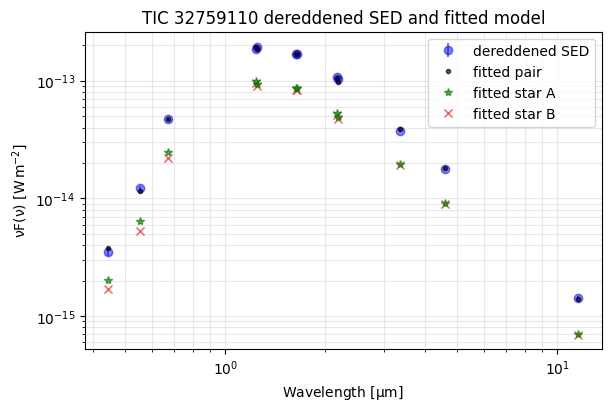

In [38]:
print(f"Best fit parameters for {target} from minimization fit",
      *(f"\n{l:>9s} = {t: .3f} {u:unicode}" for t, (l, u) in zip(theta_fit, theta_labels)))
plot_fitted_model(theta_fit)

### Perform MCMC fitting for more reliable fit from a probability distribution
With the MCMC fit we check every 1000 iterations whether the fit has converged and we've exceeded
the autocorrelation time (the number of steps to "forget" the starting position) by x100. If these
criteria are met we can stop the fit early.

In [39]:
_nwalkers, _niters = 100, 10000
_init_sigma = np.array([1000, 1000, 1, 1]) * 0.05
_rng = np.random.default_rng(42)
_p0 = [theta0 + _rng.normal(0, _init_sigma) for _ in range(int(_nwalkers))]

with warnings.catch_warnings(category=RuntimeWarning):
    warnings.filterwarnings("ignore") #, message="(?:.*)invalid value encountered in scalar subtract")
    with Pool(processes=None) as pool:
        print(f"Running MCMC for up to {_niters:,} iterations with {_nwalkers} walkers.")
        sampler = emcee.EnsembleSampler(_nwalkers, ndim=len(theta0), log_prob_fn=objective_func,
                                        args=obj_args, kwargs={ "maximizable": True }, pool=pool)

        prev_tau = np.inf
        for sample in sampler.sample(initial_state=_p0, iterations=_niters, progress=True):
            if sampler.iteration % 1000 == 0:
                # autocorrelation time; steps to effectively "forget" start position
                tau = sampler.get_autocorr_time(tol=0)
                if all(tau < sampler.iteration / 100) and all(abs(prev_tau - tau) / tau < 0.01):
                    print(f"Halting the MCMC after {sampler.iteration:,} iterations as we've",
                           "passed 100 times the autocorrelation time and the fit has converged.")
                    break
                prev_tau = tau

Running MCMC for up to 10,000 iterations with 100 walkers.


100%|██████████| 10000/10000 [06:00<00:00, 27.70it/s]


Mean Acceptance fraction:    0.431741
Autocorrelation steps (tau): 82.821, 82.956, 92.587, 93.650
Estimated burn-in steps:     187


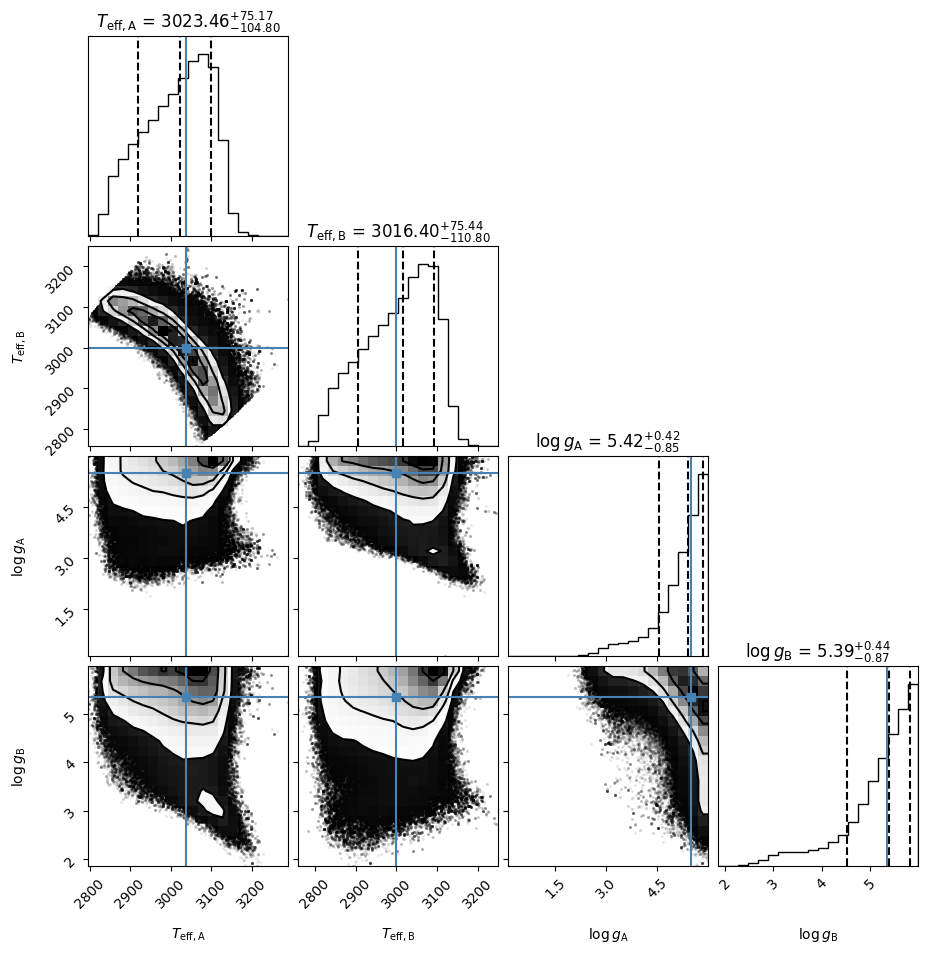

In [40]:
_accept_frac = np.mean(sampler.acceptance_fraction)
print(f"Mean Acceptance fraction:    {_accept_frac:.6f}")

try:
    tau = sampler.get_autocorr_time(c=1)
except AutocorrError as err:
    print(f"\033[93m\033[1m{err}\033[0m")
    tau = err.tau
print(f"Autocorrelation steps (tau):", ", ".join(f"{t:.3f}" for t in tau))

_burn_in_steps = int(max(np.nan_to_num(tau, copy=True, nan=1000)) * 2)
print(f"Estimated burn-in steps:     {_burn_in_steps:,}")

# thin; every nth step from the chain
samples = sampler.get_chain(discard=_burn_in_steps, thin=max(1, int(1/(1-max(_accept_frac, 0.1)))), flat=True)
_fig = corner.corner(samples, show_titles=True, plot_datapoints=True, quantiles=[0.16, 0.5, 0.84],
                     labels=[r"$T_{\rm eff,A}$", r"$T_{\rm eff,B}$", r"$\log{g}_{\rm A}$", r"$\log{g}_{\rm B}$"],
                     truths=theta_fit)
plt.show(_fig)
plt.close(_fig)

Best fit parameters for TIC 32759110 from MCMC fit 
    TeffA =  3023.456 +/- 75.170/104.799 K 
    TeffB =  3016.403 +/- 75.433/110.801 K 
    loggA =  5.420 +/- 0.422/0.849 dex 
    loggB =  5.395 +/- 0.439/0.872 dex


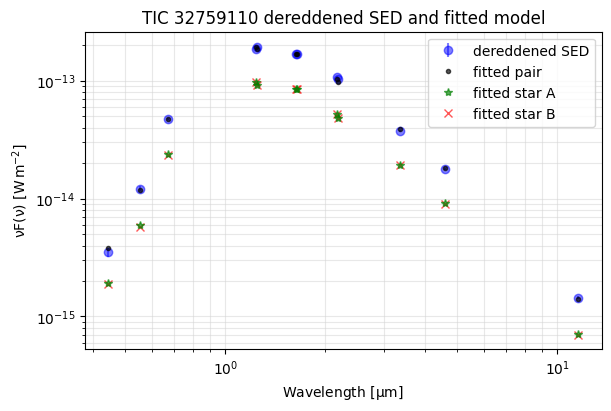

In [41]:
theta_fit = np.median(samples[_burn_in_steps:], axis=0)
theta_err_high = np.quantile(samples[_burn_in_steps:], 0.84, axis=0) - theta_fit
theta_err_low = theta_fit - np.quantile(samples[_burn_in_steps:], 0.16, axis=0)

print(f"Best fit parameters for {target} from MCMC fit",
      *(f"\n{l:>9s} = {t: .3f} +/- {fh:.3f}/{fl:.3f} {u:unicode}" for t, fh, fl, (l, u) 
                        in zip(theta_fit, theta_err_high, theta_err_low, theta_labels)))
plot_fitted_model(theta_fit)